# Fundamentals of Machine Learning - Exercise 6
Deadline: 2021.02.05, 16:00

Zhao SUN, Johannes Kammerer, Tong Yu

## 2. Bias and Variance of Ridge Regression (8 points)

Prove that expectation and covariance matrix of the regularized solution are as given.

# 

In [1]:
import numpy as np       
import matplotlib.pyplot as plt         
%matplotlib inline
from IPython.display import display, Markdown, Latex

import scipy.sparse
from scipy.sparse.linalg import lsqr

## 3. Denoising CT Image (11 points)

In [2]:
def construct_X(M, alphas, Np = None, tau=0):
    
    # Define the sensorsize Np
    if Np is None:
        Np = int(np.sqrt(2) * M)
        if Np % 2 == 0:
            Np += 1
    
    # Create the empty sparse A
    X = scipy.sparse.dok_matrix((M*M, len(alphas)*Np))
    # Fill it
    for i, alpha in enumerate(alphas):
        alph_rad = np.radians(alpha)
        rot_mat = np.array([[np.cos(alph_rad), -np.sin(alph_rad)],
                            [np.sin(alph_rad), np.cos(alph_rad)]])
        
        for y in range(M):
            for x in range(M):
                # Center the coordinates and rotate them
                p = x - (M-1) / 2.0
                q = y - (M-1) / 2.0
                p,q = rot_mat.dot([p,q])
                pos = p + (Np-1)/2.
                
                # Find the two neighboring bins
                bin0 = int(np.floor(pos))
                bin1 = int(np.ceil(pos))
                
                # Updating A
                if bin0 == bin1:
                    X[y*M + x, i*Np + bin0] = 1.0
                else:
                    val0 = bin1 - pos
                    val1 = pos - bin0
                    
                    if bin1 == 0:
                        X[y*M + x, i*Np] = val1
                    elif bin0 == Np-1:
                        X[y*M + x, i*Np + bin0] = val0
                    else:
                        X[y*M + x, i*Np + bin0] = val0
                        X[y*M + x, i*Np + bin1] = val1                
    
    if tau == 0:
        return X.T
    else:
        D = X.shape[0]
        I = scipy.sparse.identity(D)*np.sqrt(tau)
        return scipy.sparse.vstack([X.T, I])
    


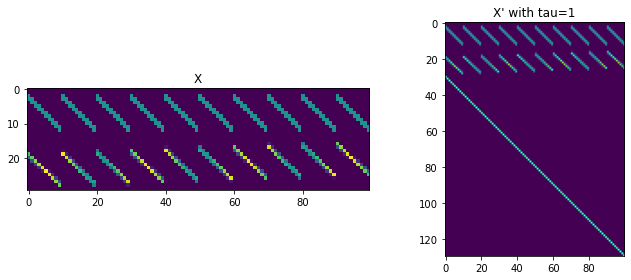

In [3]:
X_1 = construct_X(M=10,alphas=[0,20],Np = None, tau=0).toarray()
X_2 = construct_X(M=10,alphas=[0,20],Np = None, tau=1).toarray()

fig, ax = plt.subplots(1,2, figsize=(10,4),tight_layout=True)
ax[0].imshow(X_1)
ax[0].set_title("X")

ax[1].imshow(X_2)
ax[1].set_title("X' with tau=1");


#### Reconstruct the tomogram for 64 angles with $τ$ = 0, 1, 10, 100, 1000, 10000 and display the resulting CT images. Find the value of $τ$ with the best compromise of image sharpness and noise.

In [ ]:
tau = 0
M = 195
Np = 275
n = 64

alphas = np.load("hs_tomography/alphas_195.npy")
select_alphas = np.arange(n)*int(len(alphas)/n)
alphas_ = alphas[select_alphas]

y = np.load("hs_tomography/y_195.npy")
select_y = []
for k in select_alphas:
    select_y.extend(np.arange(k*Np,(k+1)*Np))
y_ = y[select_y] 

X_ = construct_X(M,alphas_,Np,tau)
print(y.shape, y_.shape, X_.shape)

beta_ = lsqr(X_, y_, atol = 1e-05, btol = 1e-05)[0]


In [20]:
taus = [0, 1, 10, 100, 1000, 10000]
y_ = np.concatenate([y_,np.zeros(M*M)])

beta_taus = [beta_]
for tau in taus[1:]:
    X_ = construct_X(M,alphas_,Np,tau)
    beta_taus.append(lsqr(X_, y_, atol = 1e-05, btol = 1e-05)[0])


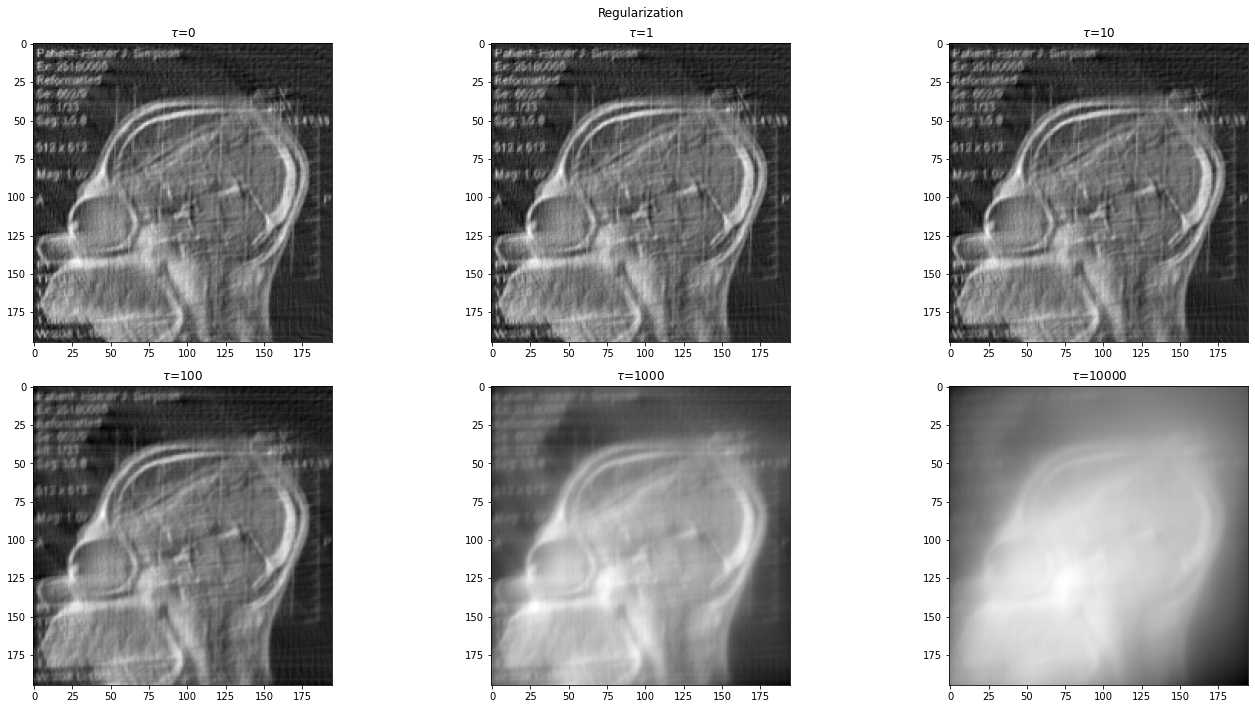

In [21]:
fig, axes = plt.subplots(2,3, figsize=(20,10),tight_layout=True)
fig.suptitle('Regularization')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(beta_taus[i].reshape(M,M),cmap='gray')
    ax.set_title(f'$τ$={taus[i]}')


COMMENTS: $τ$ = 10 probably offers the best trade-off between image sharpness and noise.

### Comparison with Gaussian Filtering

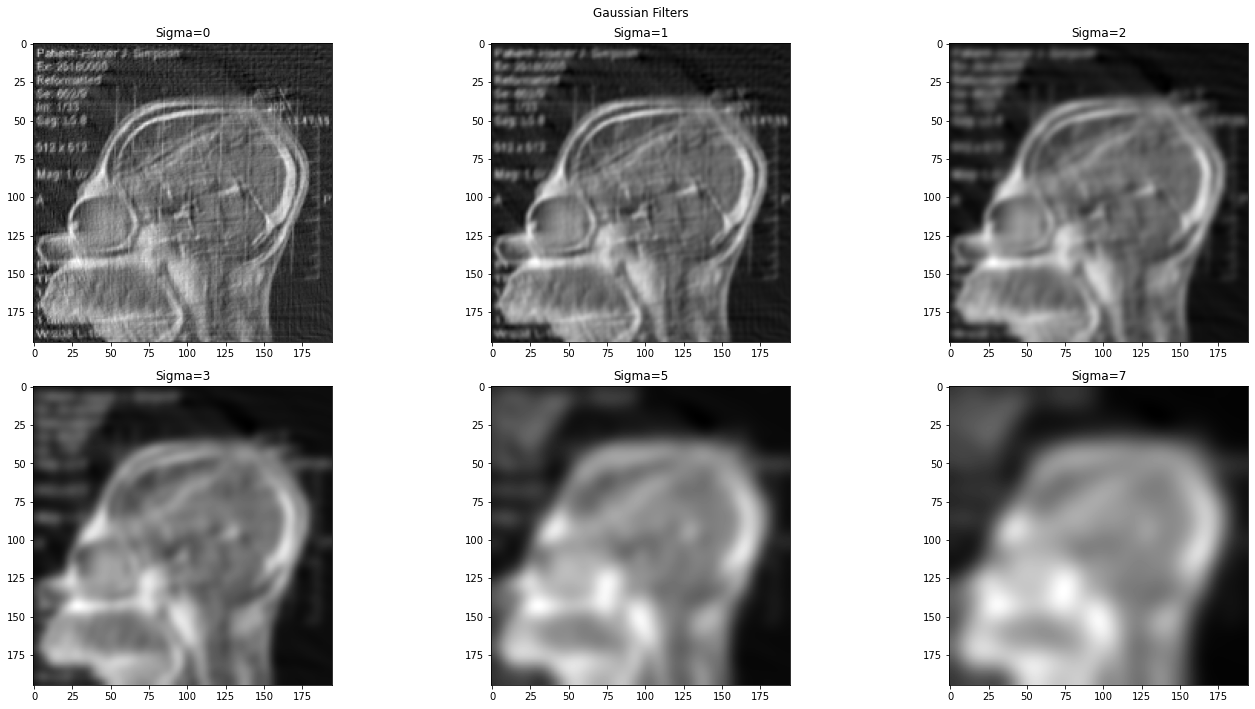

In [19]:
from scipy.ndimage.filters import gaussian_filter

sigma = [0,1,2,3,5,7]

fig, axes = plt.subplots(2,3, figsize=(20,10),tight_layout=True)
fig.suptitle('Gaussian Filters')
for i, ax in enumerate(axes.flatten()):
    img = gaussian_filter(beta_.reshape(M,M),sigma[i])
    ax.imshow(img,cmap='gray')
    ax.set_title(f'Sigma={sigma[i]}')


COMMENTS: In comparison with ridge regression, Gaussian filtering removes noises by 'blending' neighbouring pixels together and the edges in the resulting image are increasingly blurred at a higher sigma value. The ridge regression, on the other hand, is able to retain the sharpness of edges even at a higher tau value.


# 
## 4. Automatic feature selection for regression
### 4.1 Implement Orthogonal Matching Pursuit (5 points)
*Orthogonal Matching Pursuit* is a simple greedy sparse regression algorithm. It approximates the exact algorithms for least squares with L0 or L1 regularization. Implement this algorithm as a function.

In [6]:
def omp_regression(X,y,T):
    """
    Inputs:
    X: matrix of size N × D
    y: vector of size N
    T: positive int, the desired number of non-zero elements in the final solution β^(T)
    Returns: β^(t) for t = 1 . . . T as a D × T matrix, i.e. the inactive elements in each solution are not dropped, but explicitly set to zero
    """
    N, D = X.shape
    
    # initialise
    r = y
    A = []
    B = [i for i in range(D)]
    betas = np.zeros((D,T))
    lse = np.zeros(T)
    #print('betas.shape=',betas.shape,'r.shape=',r.shape)
    
    for t in range(T):
        j = np.abs(np.dot(X[:,B].T,r)).argmax()
    
        # update
        A.append(j)
        del B[j]
        
        beta = np.linalg.lstsq(X[:, A], y)[0]
        #print(f't={t}>>> j={j}, beta={beta.shape, beta}, X[:, A].shape={X[:, A].shape}')

        r = y - np.dot(X[:, A], beta)
        betas[A,t] = beta.T
        lse[t] = np.square(r).sum()
        #print(f'>>>>>> r={r.shape}, betas={betas}')
        
    return betas,lse


In [5]:
r = np.arange(10)
np.square(r).sum()

285

### 4.2 Classification with sparse LDA (8 points)

Now execute omp_regression() with sufficiently big T to get the sequence of sparse LDA solutions for t = 1...T.

Report the error rate on the test set for t = 1...T. How many pixels should be used for acceptable error rates? Is it necessary/beneficial to standardize the data before training and testing?

Visualize in which order the pixels are switched to active as t increases, and show if a pixel votes in favour or against class '1'. 

What is a good criterion for this distinction? Compare these results with your hand-crafted feature selection in exercise 2 - did you select the same pixels?

In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X = digits.data
y = digits.target

# Select only the digit 1 and 7
X_select = X[np.logical_or(y == 1, y == 7)]
y_select = y[np.logical_or(y == 1, y == 7)]
y_relabel = np.where(y_select==7, -1, y_select)

# Split data into training and test sets with 80%/20%
X_train, X_test, y_train , y_test = train_test_split(X_select, y_relabel, train_size=0.8, random_state =0, shuffle=True)

def normalize(x):
    return (x - x.min()) / (x.max()-x.min())

def standardize(x):
    return (x - x.mean()) / x.std()

# standardize data
X_train = standardize(X_train) 
X_test = standardize(X_test)

print("Training set: ",X_train.shape, np.unique(y_train,return_counts=True), 
      "\nTesting set: ",X_test.shape, np.unique(y_test,return_counts=True))


Training set:  (288, 64) (array([-1,  1]), array([136, 152], dtype=int64)) 
Testing set:  (73, 64) (array([-1,  1]), array([43, 30], dtype=int64))


(64, 64) 58
[16 12 18 17 15 14 11 10  9 13  7  6  5  4  3  8  2 20 19 45 27 26  1 51
 50 29 28 60 47 48 46 21 49 54 52 53 55 63 59 62 61 58 25 22 56 23 57 24
  0 38 39 36 31 37 40 35 43 34 33 32 44 41 30 42]
[0.         0.         0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.02739726 0.04109589
 0.04109589 0.05479452 0.05479452 0.05479452 0.05479452 0.06849315
 0.06849315 0.06849315 0.06849315 0.06849315 0.06849315 0.06849315
 0.06849315 0.06849315 0.06849315 0.08219178 0.08219178 0.08219178
 0.08219178 0.08219178 0.08219178 0.08219178 0.08219178 0.09589041
 0.09589041 0.09589041 0.09589041 0.09589041 0.10958904 0.10958904
 0.1369863  0.42465753 0.43835616 0.43835616 0.43835616 0.45205479
 0.46575342 0.47945205 0.52054795 0.53424658 0.53424658 0.53424658
 0.5890411  0.60273973 0.67123288 0.75342466]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


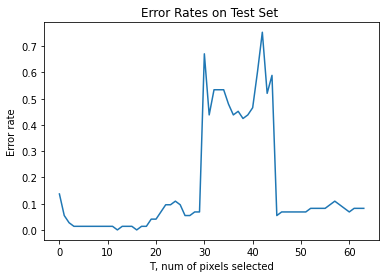

In [9]:
T = 64
solutions_train,lse = omp_regression(X_train, y_train, T)
print(solutions_train.shape,np.argmin(lse))

errors = []
for t in range(T):
    beta = solutions_train[:,t:t+1]
    pred = X_test.dot(beta)
    pred = np.where(pred>=0,1,pred)
    pred = np.where(pred<0,-1,pred)
    err = np.sum(pred.flatten()!=y_test) / len(y_test)
    errors.append(err)

plt.plot(errors)
plt.title("Error Rates on Test Set ")
plt.xlabel("T, num of pixels selected")
plt.ylabel("Error rate");

np.array(errors)

idx = np.array(errors).argsort()
print(idx)
print(np.sort(errors))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


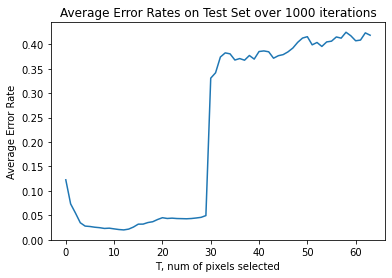

In [236]:
# Try with different random seeds

T = 64
S = 1000
errors = np.zeros((S,T))
solutions = np.zeros((S,64,T))
for s in range(S):
    X_train, X_test, y_train , y_test = train_test_split(X_select, y_relabel, train_size=0.8, random_state=s, shuffle=True)
    X_train = standardize(X_train) 
    X_test = standardize(X_test)
    
    solutions_train,lse = omp_regression(X_train, y_train, T)
    solutions[s,:,:] = solutions_train
    
    for t in range(T):
        beta = solutions_train[:,t:t+1]
        pred = X_test.dot(beta)
        pred = np.where(pred>=0,1,pred)
        pred = np.where(pred<0,-1,pred)
        err = np.sum(pred.flatten()!=y_test) / len(y_test)
        errors[s,t] = err

plt.plot(errors.mean(axis=0))
plt.title(f"Average Error Rates on Test Set over {S} iterations")
plt.xlabel("T, num of pixels selected")
plt.ylabel("Average Error Rate");


In [237]:
#print(np.array(errors.mean(axis=0)).argsort())
#print(np.sort(errors.mean(axis=0)))
print("For error rate < 5% : eligible T=", np.argwhere(errors.mean(axis=0)<0.05).flatten())

For error rate < 5% : eligible T= [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29]


COMMENTS: Between 3 and 29 pixels should be selected. It is beneficial to standardize the data before training. 

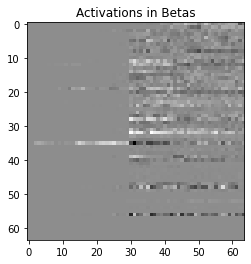

In [253]:
plt.imshow(solutions.mean(axis=0),cmap='gray')
plt.title("Activations in Betas");

COMMENTS: pixel no. 35, 19 and 12 are probably the most prominent. We only overlapped at pixel 12 in our solution for Ex02

### 4.3 One-against-the-rest classification (8 points)

A *one-against-the-rest classifier* is actually a collection of C classifiers, one for each class k.

Use these auxiliary training sets to train a sparse LDA for the digits k = 0 . . . 9 with suitable T (all classifiers should use the same T)

Report the confusion matrix of your predictor on the test set

Why is it useful to introduce class 'unknown'? Parameterize your classifier such that a few test instances are actually assigned to this class and visualize these instances. What do you observe?

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


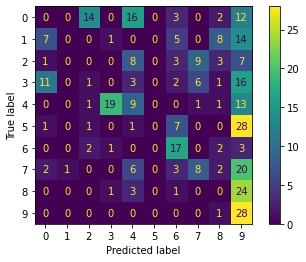

In [417]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
                                 
digits = load_digits()
digits.keys()

X_train, X_test, y_train , y_test = train_test_split(digits['data'], digits['target'], train_size=0.8, random_state= 3, shuffle=True)

targets, counts = np.unique(y_train,return_counts=True)
train_total = len(y_train)

T = 19

# Set up empty container for classifiers
classifiers = np.zeros((64,10)) 

for i,target in enumerate(targets):
    # Create auxiliary training dataset (50% target digit, 50% other digits randomly chosen)
    others_idx = np.random.permutation(train_total - counts[i])[:counts[i]]
    X_train_ = np.vstack([X_train[y_train==target], X_train[y_train!=target][others_idx]])
    y_train_ = np.hstack([y_train[y_train==target], y_train[y_train!=target][others_idx]])
    
    # Train a classifier for this specific target
    classifiers[:,i] = omp_regression(X_train_, y_train_, T)[:,-1]

# Prediction at Testing

out = X_test.dot(classifiers)
idx = out.argmax(axis=1)
y_pred = np.where(np.amax(out,axis=1)<0,np.nan,idx)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot();